In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/GOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,26.549999,30.150000,26.549999,29.900000,22.277349,94100.0
1,1/3/2013,29.900000,30.250000,29.350000,29.700001,22.128332,30600.0
2,1/4/2013,29.900000,32.000000,29.600000,31.950001,23.804724,59000.0
3,1/7/2013,31.950001,32.200001,31.100000,31.650000,23.581205,31700.0
4,1/8/2013,31.500000,31.850000,31.250000,31.299999,23.320431,25000.0


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: -449.640018.3, cost: nan, total money: 9362.269983
epoch: 20, total rewards: nan.3, cost: nan, total money: nan
epoch: 30, total rewards: -134.100057.3, cost: nan, total money: 9762.949943
epoch: 40, total rewards: -381.179999.3, cost: nan, total money: 9607.430000
epoch: 50, total rewards: -1133.659995.3, cost: nan, total money: 8774.740005
epoch: 60, total rewards: -929.669992.3, cost: nan, total money: 8827.840008
epoch: 70, total rewards: -1006.559994.3, cost: nan, total money: 8960.320006
epoch: 80, total rewards: -467.029976.3, cost: nan, total money: 9487.440025
epoch: 90, total rewards: -296.839970.3, cost: nan, total money: 9646.180029
epoch: 100, total rewards: nan.3, cost: nan, total money: nan
epoch: 110, total rewards: -953.859994.3, cost: nan, total money: 8882.550005
epoc

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 31.299999, total balance 9968.700001
day 6: buy 1 unit at price 31.000000, total balance 9937.700001
day 8: buy 1 unit at price 30.400000, total balance 9907.300001
day 10, sell 1 unit at price 31.000000, investment -0.958464 %, total balance 9938.300001,
day 12, sell 1 unit at price 34.000000, investment 9.677419 %, total balance 9972.300001,
day 17, sell 1 unit at price 36.349998, investment 19.572365 %, total balance 10008.650000,
day 18: buy 1 unit at price 36.049999, total balance 9972.600000
day 21, sell 1 unit at price 33.049999, investment -8.321775 %, total balance 10005.650000,
day 25: buy 1 unit at price 31.299999, total balance 9974.350000
day 31, sell 1 unit at price 32.950001, investment 5.271570 %, total balance 10007.300001,
day 36: buy 1 unit at price 35.000000, total balance 9972.300001
day 39: buy 1 unit at price 35.000000, total balance 9937.300001
day 40, sell 1 unit at price 33.450001, investment -4.428569 %, total balance 9970.750002,
d

day 628, sell 1 unit at price 18.950001, investment -10.823526 %, total balance 9713.050005,
day 629: buy 1 unit at price 19.750000, total balance 9693.300005
day 632: buy 1 unit at price 17.700001, total balance 9675.600004
day 638, sell 1 unit at price 20.200001, investment -2.179171 %, total balance 9695.800005,
day 640, sell 1 unit at price 21.700001, investment 7.160498 %, total balance 9717.500006,
day 652: buy 1 unit at price 20.400000, total balance 9697.100006
day 653: buy 1 unit at price 20.100000, total balance 9677.000006
day 661: buy 1 unit at price 17.450001, total balance 9659.550005
day 665, sell 1 unit at price 12.850000, investment -33.246751 %, total balance 9672.400005,
day 670: buy 1 unit at price 15.250000, total balance 9657.150005
day 673, sell 1 unit at price 14.500000, investment -26.208650 %, total balance 9671.650005,
day 674: buy 1 unit at price 14.450000, total balance 9657.200005
day 680: buy 1 unit at price 13.600000, total balance 9643.600005
day 681, s

day 1218: buy 1 unit at price 8.070000, total balance 9632.430006
day 1219: buy 1 unit at price 7.790000, total balance 9624.640006
day 1224, sell 1 unit at price 7.880000, investment -0.126740 %, total balance 9632.520006,
day 1230: buy 1 unit at price 7.330000, total balance 9625.190006
day 1233, sell 1 unit at price 8.100000, investment 1.250005 %, total balance 9633.290007,
day 1235: buy 1 unit at price 8.170000, total balance 9625.120007
day 1239, sell 1 unit at price 8.470000, investment -2.080917 %, total balance 9633.590007,
day 1245: buy 1 unit at price 8.690000, total balance 9624.900007
day 1246: buy 1 unit at price 8.560000, total balance 9616.340007
day 1247, sell 1 unit at price 8.370000, investment -9.317440 %, total balance 9624.710007,
day 1252, sell 1 unit at price 7.810000, investment -16.111712 %, total balance 9632.520007,
day 1254: buy 1 unit at price 7.970000, total balance 9624.550007
day 1255: buy 1 unit at price 7.980000, total balance 9616.570007
day 1259, se

day 1591: buy 1 unit at price 5.820000, total balance 9675.040007
day 1596: buy 1 unit at price 5.560000, total balance 9669.480007
day 1600: buy 1 unit at price 5.470000, total balance 9664.010007
day 1602: buy 1 unit at price 5.220000, total balance 9658.790007
day 1604: buy 1 unit at price 5.310000, total balance 9653.480007
day 1606: buy 1 unit at price 5.220000, total balance 9648.260008
day 1607: buy 1 unit at price 5.210000, total balance 9643.050008
day 1613, sell 1 unit at price 4.750000, investment -11.380599 %, total balance 9647.800008,
day 1615, sell 1 unit at price 4.360000, investment -16.793887 %, total balance 9652.160008,
day 1619: buy 1 unit at price 4.780000, total balance 9647.380007
day 1624, sell 1 unit at price 4.650000, investment -5.487804 %, total balance 9652.030008,
day 1628: buy 1 unit at price 5.290000, total balance 9646.740008
day 1631: buy 1 unit at price 5.250000, total balance 9641.490008
day 1634: buy 1 unit at price 5.810000, total balance 9635.680

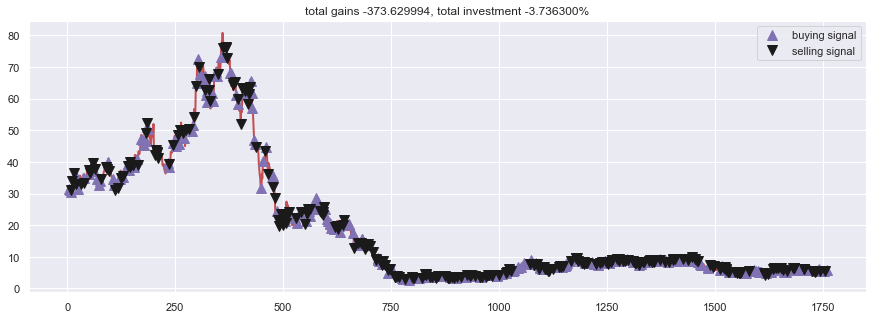

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()